# 1. Functional API

**`tf.keras.Sequential` 模型假设 NN 只有 1 个输入和 1 个输出，而且 NN 是层的线性堆叠。**

这是一个经过普遍验证的假设。这种 NN 配置非常常见，能处理许多任务。

但**有些情况下这种假设过于死板**。有的 NN 可能有多个独立的 inputs，或 (同时) 有多个 outputs，或 (同时) 在层与层之间具有内部分支，这使得 NN 看起来像是层构成的**图 (graph)**，而不是层的线性堆叠。

![sequential](figs/chap07-figs/sequential.png)

<br>

- **<font color='blue'>多模态输入 (multimodal inputs)</font>**。<font color='crimson'>需要合并来自不同输入源的数据，并使用不同类型的神经层处理不同类型的数据。</font>

  如用以下输入预测一件二手衣服最有可能的市场价格：
  
  - 用户提供的元数据 (metadata)，含商品品牌、已使用年限。如果只有这部分数据，可以使用 one-hot 编码，然后使用密集连接网络来预测价格。

  - 用户提供的文本描述。如果只有这部分数据，可以使用 RNN 或者 1D convnet。
  
  - 商品图片。如果只有这部分数据，可以使用 2D convnet。

  <font color='crimson'>如果同时有这 3 中数据，可以独立训练 3 个模型，然后对 3 者的预测加权平均。这种方法可能不是最优的，因为模型提取的信息可能存在冗余。</font>
  
  <font color='blue'>更好的方法是使用一个可以同时查看所有可用输入的模型，从而联合学习一个更加精确的数据模型——这个模型具有 3 个输入分支。</font>

![多输入模型](figs/chap07-figs/multi_inputs.png)

- **<font color='blue'>多输出模型</font>**。如给定一部小说的文本，希望按类别 (爱情/惊悚) 分类，同时还希望预测大致写作日期。可以独立地训练多个模型，分别用于划分类别和预测日期。但<font color='crimson'>由于这些属性并不是统计无关的，你可以构建一个更好的模型，用这个模型来学习同时预测类别和日期</font>。这种联合模型将有两个输出，或者说两个头 (head)。<font color='crimson'>因为类别和日期之间具有相关性，所以知道小说的写作日期有助于模型在小说类别的空间中学到丰富而又准确的表示，反之亦然</font>。

![多输出模型](figs/chap07-figs/multi_outputs.png)


- **<font color='blue'>有向无环图</font>**

  - Inception 系列网络依赖于 **<font color='red'>Inception</font>** 模块，其输入被多个并行的卷积分支所处理，然后将这些分支的输出合并为单个张量。
  - **<font color='red'>残差连接 (residual connection)</font>** 将前面的输出张量与后面的输出张量相加，从而将前面的 表示重新注入下游数据流中，这有助于防止信息处理流程中的信息损失。

![inception](figs/chap07-figs/Inception.png)

![residual_connection](figs/chap07-figs/residual_connection.png)

## 1. Functional API 介绍

<font color='crimson'>使用函数式 API，可以直接操作张量，也可以把层当作函数来使用，接收张量并返回张量 (因此得名函数式 API)。</font>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Sequential model
sequential_model = tf.keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(64,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')
])

sequential_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


In [3]:
# Model
tf.keras.backend.clear_session()

input_tensor = tf.keras.Input(shape=(64,))
x = layers.Dense(32, activation='relu')(input_tensor)
x = layers.Dense(32, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)
# 将输入张量和输出张量转换为一个模型
model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)  # Notice!

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


注意模型第一层输出 shape。

**<font color='crimson'>将 Model 对象实例化只用了一个输入张量一个输出张量。Keras 会在后台检索从 input_tensor 到 output_tensor 包含的每一层，并将这些层组合成一个类图的数据结构，即一个 Model。</font>** 这种方法有效的原因在于，**<font color='crimson'>output_tensor 是通过对 input_tensor 进行多次变换得到的</font>**。如果你试图利用不相关的输入和输出来构建一个模型，那么会得到 RuntimeError。

<font color='blue'>对这种 Model 实例进行编译、训练或评估时，其 API 与 Sequential 模型相同。</font>

In [4]:
# Generate data
x_train = np.random.random((1000, 64))
y_train = np.random.random((1000, 10))

In [5]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.evaluate(x_train, y_train, verbose=0)  # 必须先 compile

11.939699447631837

## 2. Multi-inputs model (question-answering model)

函数式 API 可用于构建具有多个输入的模型。通常情况下，这种模型会在某一时刻用一个可以组合多个张量的层将不同的输入分支合并，张量组合方式可能是相加、连接等。这通常利用 Keras 的合并运算来实现，比如 `tf.keras.layers.add`、`tf.keras.layers.concatenate`等。

**<font color='blue'>典型的问答模型有两个输入</font>**：一个自然语言描述的问题和一个文本片段 (比如新闻文章)， 后者提供用于回答问题的信息。然后模型要生成一个回答，在最简单的情况下，这个回答只包含一个词，可以通过对某个预定义的词表做 softmax 得到。

![question_answering_model](figs/chap07-figs/question_answering_model.png)

In [7]:
# Build the model
tf.keras.backend.clear_session()

text_vocab_size = 10000
question_vocab_size = 10000
answer_vocab_size = 500

# 文本输入是一个长度可变的整数序列
# 可以选择对输入命名
text_input = tf.keras.Input(shape=(None,), dtype='int32', name='text')
# 将输入嵌入长度为 64 的向量
embedded_text = layers.Embedding(
    # Size of the vocabulary, i.e. maximum integer index + 1.
    text_vocab_size,
    # Dimension of the dense embedding.
    64)(text_input)
# 利用 LSTM 将向量编码为单个向量
encoded_text = layers.LSTM(32)(embedded_text)

# 使用不同的层实例
question_input = tf.keras.Input(shape=(None,), dtype='int32', name='question')
embedded_question = layers.Embedding(question_vocab_size, 32)(question_input)
encoded_question = layers.LSTM(16)(embedded_question)

# Default axis=-1. Axis along which to concatenate.
# concatenated = layers.Concatenate(axis=-1)([encoded_text, encoded_question])
concatenated = layers.concatenate([encoded_text, encoded_question],  # A list of input tensors (at least 2).
                                  axis=-1)
answer = layers.Dense(answer_vocab_size, activation='softmax')(concatenated)

model = tf.keras.Model(inputs=[text_input, question_input], outputs=answer)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
question (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     640000      text[0][0]                       
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 32)     320000      question[0][0]                   
______________________________________________________________________________________________

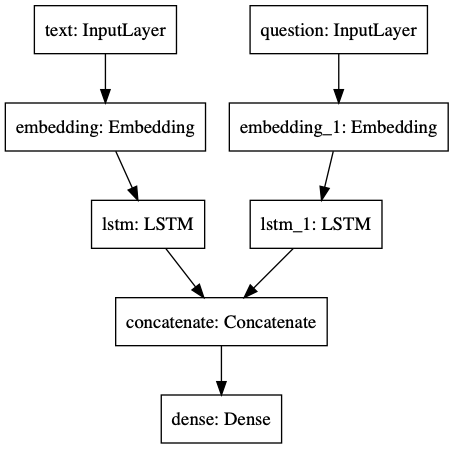

In [8]:
tf.keras.utils.plot_model(model, './figs/chap07-figs/qa_model.png')

In [9]:
# Generate data
num_samples = 1000
max_length = 100

text = np.random.randint(1, text_vocab_size, size=(num_samples, max_length))
question = np.random.randint(1, question_vocab_size, size=(num_samples, max_length))

# 回答是 one-hot 编码
answers = np.random.randint(answer_vocab_size, size=(num_samples))
answers = tf.keras.utils.to_categorical(answers, answer_vocab_size)

In [10]:
# Train the model - 1
model.fit([text, question],
          answers,
          epochs=1,
          batch_size=128,
          validation_data=([text, question], answers))

Train on 1000 samples, validate on 1000 samples
1000/1000 [==============================] - 3s 3ms/sample - loss: 6.2146 - acc: 0.0020 - val_loss: 6.1997 - val_acc: 0.0940


In [11]:
# Train the model - 2
model.fit({'text': text, 'question': question},  # 必须对 Input 进行命名
          answers,
          epochs=1,
          batch_size=128)

Train on 1000 samples
1000/1000 [==============================] - 0s 474us/sample - loss: 6.1972 - acc: 0.0470


In [12]:
# Evaluate - 1
model.evaluate(([text, question]), answers, verbose=2)

1000/1000 - 0s - loss: 6.1759 - acc: 0.1120


[6.175883869171143, 0.112]

In [13]:
# Evaluate - 2
model.evaluate({'text': text, 'question': question}, answers, verbose=0)

[6.175883869171143, 0.112]

In [14]:
# Predict - 1
model.predict([text, question])  # shape (1000, 500)

array([[0.00202294, 0.00191266, 0.0019711 , ..., 0.00203171, 0.00211302,
        0.00197274],
       [0.00202502, 0.00190334, 0.00196059, ..., 0.00205166, 0.00213875,
        0.00198711],
       [0.00202612, 0.00194833, 0.001995  , ..., 0.00205601, 0.00210135,
        0.0019873 ],
       ...,
       [0.00202705, 0.00193196, 0.00197701, ..., 0.0020468 , 0.00208877,
        0.00198082],
       [0.00201996, 0.00195175, 0.00197714, ..., 0.00202627, 0.00210483,
        0.0019655 ],
       [0.00202228, 0.00196562, 0.0019857 , ..., 0.00203931, 0.0020875 ,
        0.00197543]], dtype=float32)

In [15]:
# Predict - 2
model.predict({'text': text, 'question': question})  # shape (1000, 500)

array([[0.00202294, 0.00191266, 0.0019711 , ..., 0.00203171, 0.00211302,
        0.00197274],
       [0.00202502, 0.00190334, 0.00196059, ..., 0.00205166, 0.00213875,
        0.00198711],
       [0.00202612, 0.00194833, 0.001995  , ..., 0.00205601, 0.00210135,
        0.0019873 ],
       ...,
       [0.00202705, 0.00193196, 0.00197701, ..., 0.0020468 , 0.00208877,
        0.00198082],
       [0.00201996, 0.00195175, 0.00197714, ..., 0.00202627, 0.00210483,
        0.0019655 ],
       [0.00202228, 0.00196562, 0.0019857 , ..., 0.00203931, 0.0020875 ,
        0.00197543]], dtype=float32)

## 3. Multi-outputs model

根据社交媒体发帖，预测发帖人的年龄、性别和收入水平等。

![multi_outputs_2](figs/chap07-figs/multi_outputs_2.png)

In [16]:
# A three-output model
vocab_size = 50000
num_income_groups = 10

posts_input = tf.keras.Input(shape=(None,), dtype='int32', name='posts')
embedded_posts = layers.Embedding(vocab_size, 256)(posts_input)
x = layers.Conv1D(128, 5, activation='relu')(embedded_posts)
x = layers.MaxPool1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.MaxPool1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.GlobalAvgPool1D()(x)
x = layers.Dense(128, activation='relu')(x)

# 输出层都具有 name
age_pred = layers.Dense(1,
                        name='age')(x)
income_pred = layers.Dense(num_income_groups,
                           activation='softmax',
                           name='income')(x)
gender_pred = layers.Dense(1,
                           activation='sigmoid',
                           name='gender')(x)

model = tf.keras.Model(inputs=posts_input,
                       outputs=[age_pred, income_pred, gender_pred])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
posts (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    12800000    posts[0][0]                      
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 128)    163968      embedding_2[0][0]                
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, None, 128)    0           conv1d[0][0]                     
____________________________________________________________________________________________

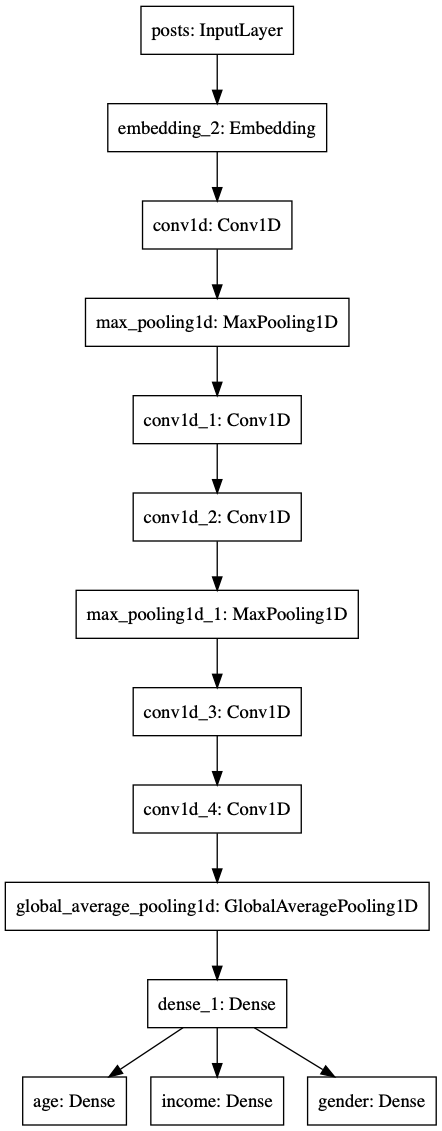

In [17]:
tf.keras.utils.plot_model(model, './figs/chap07-figs/multi_output_model.png')

重要的是，**<font color='blue'>训练这种模型需要能够对网络的各个头指定不同的损失函数。</font>** 例如，年龄预测是标量回归任务，而性别预测是二分类任务，二者需要不同的训练过程。但是，**<font color='blue'>梯度下降要求将一个标量最小化，所以为了能够训练模型，必须将这些损失合并为单个标量。合并不同损失最简单的方法就是对所有损失求和。在 Keras 中，可以在编译时使用损失组成的列表或字典来为不同输出指定不同损失，然后将得到的损失值相加得到一个全局损失，并在训练过程中将这个损失最小化。</font>**

In [18]:
# Use a different loss on each output by passing a dictionary or a list of losses.
# The loss value that will be minimized by the model will then be the sum of all individual losses.
model.compile(optimizer='rmsprop',
              # list
              loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'])

# Or
model.compile(optimizer='rmsprop',
              # dict
              loss={'age': 'mse',
                    'income': 'categorical_crossentropy',
                    'gender': 'binary_crossentropy'})

**<font color='blue'>严重不平衡的损失贡献会导致模型表示针对单个损失值最大的任务优先进行优化，而不考虑其他任务的优化。为了解决这个问题，可以为每个损失值对最终损失的贡献分配不同大小的重要性。如果不同的损失值具有不同的取值范围，那么这一方法尤其有用。</font>**

In [19]:
# The loss value that will be minimized by the model will then be the weighted sum of all individual losses,
# weighted by the these loss wight coefficients.
model.compile(optimizer='rmsprop',
              # list
              loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'],
              # If a list, it is expected to have a 1:1 mapping to the model's outputs.
              loss_weights=[0.25, 1., 10.])

# Or
model.compile(optimizer='rmsprop',
              # dict
              loss={'age': 'mse',
                    'income': 'categorical_crossentropy',
                    'gender': 'binary_crossentropy'},
              loss_weights={'age': 0.25,
                            'income': 1.,
                            'gender': 10.})

```python
# Train the model
model.fit(posts,
          [age_targets, income_targets, gender_targets],
          epochs=10,
          batch_size=64,
          validation_data=(posts, [age_targets, income_targets, gender_targets]))

# Or
model.fit(posts,
          {'age': age_targets, 'income': income_targets, 'gender': gender_targets},
          epochs=10,
          batch_size=64)
```

## 4. Mulit-inputs and multi-outputs model

试图预测 Twitter 上的一条新闻标题有多少转发和点赞数。

模型的主要输入将是新闻标题本身，即一系列词语，但是为了增添趣味，模型还添加了其他的辅助输入来接收额外的数据，例如新闻标题的发布的时间等。该模型也将通过两个损失函数进行监督学习。较早地在模型中使用主损失函数，是深度学习模型的一个良好正则方法。

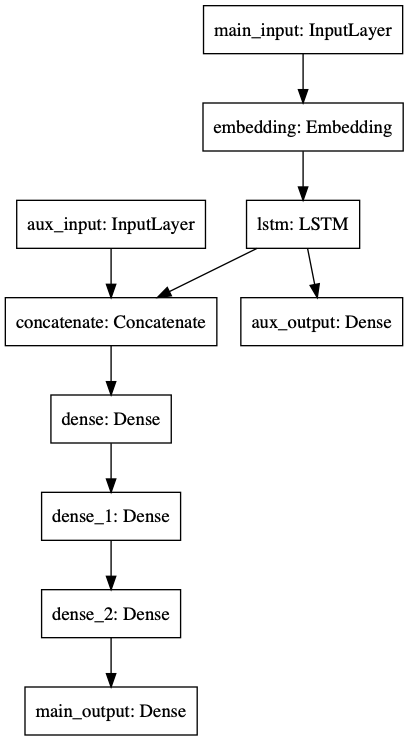

In [24]:
tf.keras.backend.clear_session()

# 标题数据：接收一个含有 100 个整数的序列，每个整数 0-10000
main_input = layers.Input(shape=(100,), dtype='int32', name='main_input')
# Embedding 层将输入序列编码为一个稠密向量的序列，每个向量维度 512
x = layers.Embedding(input_dim=10000, output_dim=100, input_length=100)(main_input)
# LSTM 层把向量序列转换成单个向量，它包含整个序列的上下文信息
lstm_out = layers.LSTM(32)(x)

# 插入辅助损失，使得即使在模型主损失很高的情况下，LSTM 层和 Embedding 层都能被平稳地训练。
aux_output = layers.Dense(1, activation='sigmoid', name='aux_output')(lstm_out)

# 将辅助输入数据与 LSTM 层的输出连接起来，输入到模型中
aux_input = layers.Input(shape=(5,), name='aux_input')
x = layers.concatenate([lstm_out, aux_input])

x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)

main_output = layers.Dense(1, activation='sigmoid', name='main_output')(x)
model = tf.keras.Model(inputs=[main_input, aux_input],
                       outputs=[main_output, aux_output])

tf.keras.utils.plot_model(model,
                          './figs/chap07-figs/multi_input_and_multi_output_model.png')

## 5. 层组成的有向无环图

还可以实现具有复杂的内部拓扑结构的网络。

Keras 中的 NN 可以是层组成的任意有向无环图 (directed acyclic graph)。无环 (acyclic) 这个限定词很重要，即这些图不能有循环。张量 x 不能成为生成 x 的某一层的输入。唯一允许的处理循环 (即循环连接) 是循环层的内部循环。

### 5.1 Inception 模块

Inception 模块最基本的形式包含 3~4 个分支，**<font color='crimson'>首先是一个 1×1 的卷积，然后是一个 3×3 的卷积，最后将所得到的特征连接在一起。这种设置有助于网络分别学习空间特征和逐通道的特征，这比联合学习这两种特征更加有效</font>**。Inception 模块也可能具有更复杂的形式，通常会包含池化运算、不同尺寸的空间卷积。

![inception](figs/chap07-figs/Inception.png)

<div class="alert alert-block alert-info">
    <b><center><font color='blue'>1x1 卷积 (逐点卷积, pointwise convolution) 的作用</font></center></b><Br>
    卷积能够在输入张量的每一个方块周围提取空间图块，并对所有图块应用相同的变换。极端情况是提取的图块只包含一个方块。这时卷积运算<font color='blue'>等价于让每个方块向量经过一个 Dense 层：它计算得到的特征能够将输入张量通道中的信息混合在一起，但不会将跨空间的信息混合在一起</font> (因为它一次只查看一个方块)。<br><br>
    这种 1×1 卷积<font color='blue'>是 Inception 模块的特色</font>，它<font color='blue'>有助于区分开通道特征学习和空间特征学习</font>。<br><br>
    <font color='blue'>如果你假设每个通道在跨越空间时是高度自相关的，但不同的通道之间可能并不高度相关，那么这种做法是很合理的。</font>
</div>

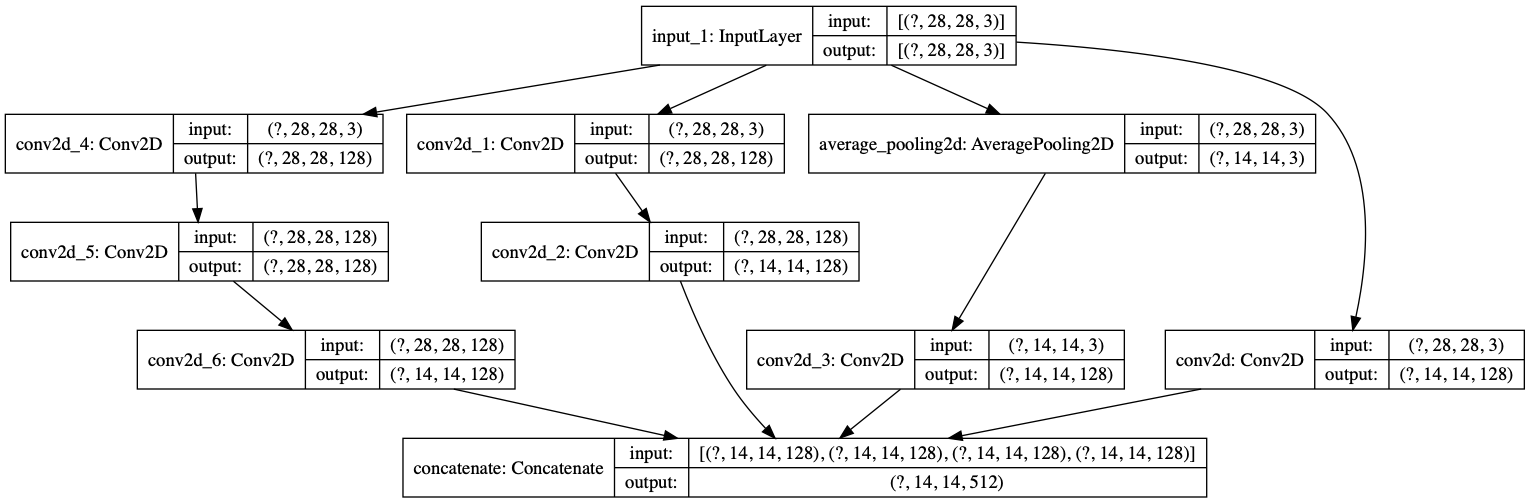

In [31]:
tf.keras.backend.clear_session()

x = layers.Input(shape=(28, 28, 3))

# 每个分支使用相同的 stride (=2)，这确保所有分支输出具有相同的尺寸，这样才能连接
branch_1 = layers.Conv2D(128, 1, strides=2, activation='relu')(x)

branch_2 = layers.Conv2D(128, 1, activation='relu')(x)
branch_2 = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(branch_2)

branch_3 = layers.AveragePooling2D(3, padding='same', strides=2)(x)
branch_3 = layers.Conv2D(128, 3, padding='same', activation='relu')(branch_3)

branch_4 = layers.Conv2D(128, 1, activation='relu')(x)
branch_4 = layers.Conv2D(128, 3, padding='same', activation='relu')(branch_4)
branch_4 = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(branch_4)

# 在 channel 上连接
output = layers.concatenate([branch_1, branch_2, branch_3, branch_4], axis=-1)

model = tf.keras.Model(inputs=x, outputs=output)
tf.keras.utils.plot_model(model, 'figs/chap07-figs/inception.png', show_shapes=True)

Xception 代表极端 Inception (extreme inception)，它是一种卷积神经网络架构，其灵感可能来自于 Inception。Xception 将分别进行通道特征学习与空间特征学习的想法推向逻辑上的极端，并将 Inception 模块替换为深度可分离卷积，其中包括一个逐深度卷积 (即一个空间卷积，分别对每个输入通道进行处理) 和后面的一个逐点卷积 (即一个 1×1 卷积)。这个深度可分离卷积实际上是 Inception 模块的一种极端形式，其空间特征和通道特征被完全分离。Xception 的参数个数与 Inception V3 大致相同，但因为它对模型参数的使用更加高效，所以在 ImageNet 以及其他大规模数据集上的运行性能更好，精度也更高。

### 5.2 残差连接

**<font color='crimson'>残差连接解决了困扰所有大规模深度学习模型的两个共性问题：梯度消失和表示瓶颈。</font>**

**<font color='blue'>通常来说，向任何多于 10 层的模型中添加残差连接，都可能会有所帮助。</font>**

<font color='crimson'>残差连接是让前面某层的输出作为后面某层的输入，从而在序列网络中有效地创造了一条捷径。</font>

<font color='blue'>前面层的输出没有与后面层的激活连接在一起，而是与后面层的激活相加 (这里假设两个激活的形状相同)。</font>如果它们的形状不同，可以用一个线性变换将前面层的激活改变成目标形状：

- 线性变换可以是不带激活的 Dense 层


- 对于卷积特征图，可以是不带激活 1×1 卷积

**<font color='crimson'>如果特征图的尺寸相同，在 Keras 中实现残差连接的方法如下，用的是恒等残差连接 (identity residual connection)。</font>**

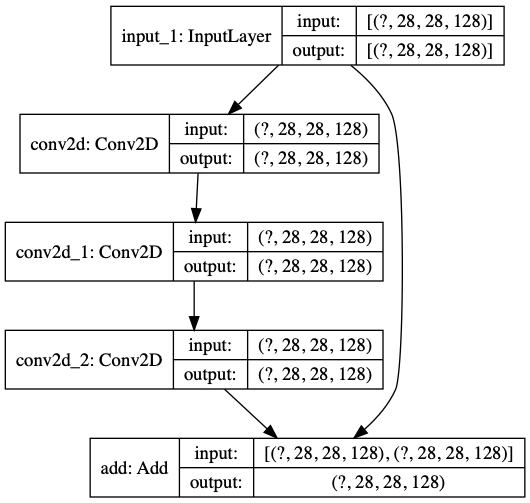

In [35]:
tf.keras.backend.clear_session()

x = layers.Input(shape=(28, 28, 128))
y = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
y = layers.Conv2D(128, 3, padding='same', activation='relu')(y)
y = layers.Conv2D(128, 3, padding='same', activation='relu')(y)

# 特征图尺寸相同
y = layers.add([y, x])  # 加上原始输入 x

model = tf.keras.Model(inputs=x, outputs=y)
tf.keras.utils.plot_model(model, 'figs/chap07-figs/residual_conn_1.png',
                          show_shapes=True)

**<font color='crimson'>如果特征图的尺寸不同，实现残差连接的方法如下，用的是线性残差连接 (linear residual connection)</font>**

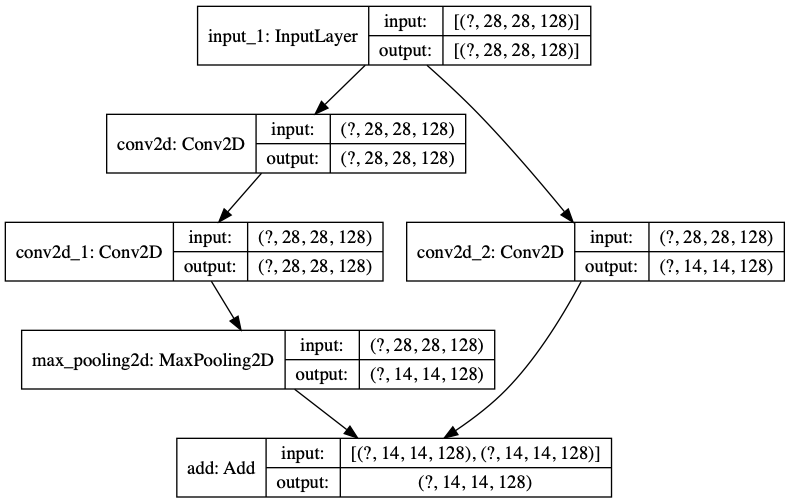

In [37]:
tf.keras.backend.clear_session()

x = layers.Input(shape=(28, 28, 128))
y = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
y = layers.Conv2D(128, 3, padding='same', activation='relu')(y)
y = layers.MaxPool2D(2, strides=2)(y)

# 特征图尺寸不同，可以不带激活的 1x1 卷积
residual = layers.Conv2D(128, 1, strides=2, padding='same')(x)
y = layers.add([y, residual])

model = tf.keras.Model(inputs=x, outputs=y)
tf.keras.utils.plot_model(model, 'figs/chap07-figs/residual_conn_2.png',
                          show_shapes=True)

<div class="alert alert-block alert-info">
    <b><center><font color='blue'>表示瓶颈</font></center></b><br>
    在 Sequential 模型中，每个连续的表示层都构建于前一层之上，这意味着它只能访问前一层激活中包含的信息。如果某一层太小 (比如特征维度太低)，那么模型将会受限于该层激活中能够塞入多少信息。<br><br>
    <b>任何信息的丢失都是永久性的。残差连接可以将较早的信息重新注入到下游数据中，从而部分解决了深度学习模型的这一问题。</b>
</div>

<div class="alert alert-block alert-info">
    <b><center><font color='blue'>梯度消失</font></center></b><br>
    反向传播是用于训练深度神经网络的主要算法，其工作原理是将来自输出损失的反馈信号向下传播到更底部的层。如果这个反馈信号的传播需要经过很多层，那么信号可能会变得非常微弱，甚至完全丢失，导致网络无法训练。这个问题被称为<b>梯度消失 (vanishing gradient)</b>。<br><br>
    <b>深度网络中存在这个问题，在很长序列上的循环网络也存在这个问题。</b>在这两种情况下，反馈信号的传播都必须通过一长串操作。<br><br>
    LSTM 层是如何在循环网络中解决这个问题的：它引入了一个携带轨道 (carry track)，可以在与主处理轨道平行的轨道上传播信息。<br><br>
    <b>残差连接引入了一个纯线性的信息携带轨道，与主要的层堆叠方向平行，从而有助于跨越任意深度的层来传播梯度。</b>
</div>

## 6. 共享层权重

函数式 API 还有一个重要特性，那就是<b>能够多次重复使用一个层实例</b>。

<font color='crimson'>如果对一个层实例调用两次，而不是每次调用都实例化一个新层，那么每次调用可以重复使用相同的权重。这样你可以构建具有共享分支的模型，即几个分支全都共享相同的知识并执行相同的运算。也就是说，这些分支共享相同的表示，并同时对不同的输入集合学习这些表示。</font>

**Example**：假设一个模型想要评估两个句子之间的语义相似度。这个模型有两个输入 (需要比较的两个句子)，并输出一个范围在 0~1 的分数，0 表示两个句子毫不相关，1 表示两个句子完全相同或只是换一种表述。这种模型在许多应用中都很有用，其中包括在对话系统中删除重复的自然语言查询。

在这种设置下，两个输入句子是可以互换的，因为语义相似度是一种对称关系，A 相对于 B 的相似度等于 B 相对于 A 的相似度。因此，学习两个单独的模型来分别处理两个输入句子是没有道理的。相反，你<font color='crimson'>需要用一个 LSTM 层来处理两个句子。这个 LSTM 层的表示 (即它的权重) 是同时基于两个输入来学习的</font>。我们将其称为**<font color='red'>连体LSTM (Siamese LSTM)</font>** 或**<font color='red'>共享 LSTM (shared LSTM)</font>** 模型。

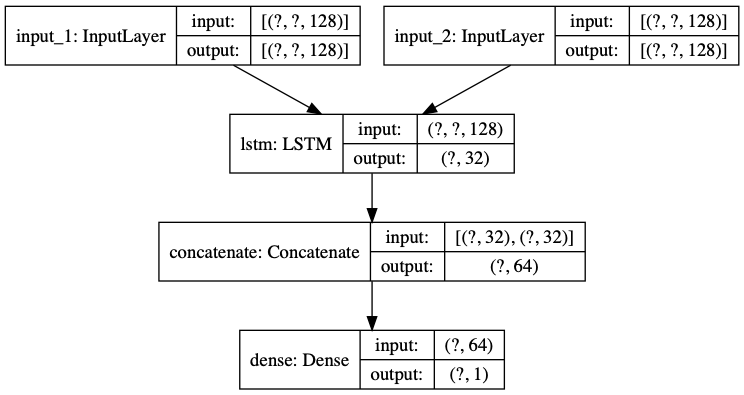

In [38]:
tf.keras.backend.clear_session()

lstm = layers.LSTM(32)

left_input = layers.Input(shape=(None, 128))
left_output = lstm(left_input)

right_input = layers.Input(shape=(None, 128))
right_output = lstm(right_input)

merged = layers.concatenate([left_output, right_output], axis=-1)

pred = layers.Dense(1, activation='sigmoid')(merged)

model = tf.keras.Model([left_input, right_input], pred)
tf.keras.utils.plot_model(model, 'figs/chap07-figs/shared_LSTM.png',
                          show_shapes=True)

## 7. 模型作为层

**在函数式 API 中，可以像使用层一样使用模型。可以将模型看作“更大的层”。**

Sequential 类和 Model 类都是如此。

这意味着可以在一个输入张量上调用模型，并得到一个输出张量。


```python
y = model(x)

y1, y2 = model([x1, x2])
```

**<font color='crimson'>在调用模型实例时，就是在重复使用模型的权重，正如在调用层实例时，就是在重复使用层的权重。调用一个实例，无论是层实例还是模型实例，都会重复使用这个实例已经学到的表示。</font>**